### **`plot_fig04_price_data.ipynb`**

#### Fig. 4: Normalized daily electricity price profile based on EPEX Spot market prices for Austria (January--April 2025).

##### Data Processing for HOURLY Tariff (2025) [Hourly Tariff – aWATTar](https://www.awattar.at/tariffs/hourly)

The **HOURLY** tariff provides electricity prices per hour based on the **EPEX Spot ® AT** market. For 2025 this yields *24 hourly prices per day*, enabling detailed analysis and consumption optimisation.

#### Processing Steps

1. **Download hourly data**:              Collect the 2025 hourly price CSV/XLSX files provided by aWATTar.
2. **Combine data**:                      Merge all files into a single `DataFrame`.
3. **Clean data**:                        Remove unnecessary columns (e.g. the `end` timestamp).
4. **Resample to 5-minute resolution**:   Use forward-fill to populate the higher-frequency index.
5. **Normalise prices**:                  Scale hourly prices to the `[0, 1]` interval.
6. **Save processed data**:               Export both raw and processed datasets (e.g. CSV/XLSX).
---

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the folder containing raw price data
price_folder = "../data"

# Collect only .xlsx files containing "marketdata"
files = sorted(
    [f for f in os.listdir(price_folder) if f.endswith(".xlsx") and "marketdata" in f]
)

# Initialize an empty DataFrame
df_all = pd.DataFrame()

for file in files:
    path = os.path.join(price_folder, file)
    df = pd.read_excel(path, nrows=1)
    print(f"{file}: {df.columns.tolist()}")

# Read and combine all matching Excel files
for file in files:
    path = os.path.join(price_folder, file)
    df = pd.read_excel(path, parse_dates=["start", "end"])
    df_all = pd.concat([df_all, df], ignore_index=True)

# Remove duplicates and sort chronologically
df_all = df_all.drop_duplicates(subset=["start"])
df_all["hour"] = df_all["start"].dt.hour

df_all = df_all.sort_values("start").reset_index(drop=True)

# Remove the 'end' column as it's not needed
df_all = df_all.drop(columns=["end"])

# Save the raw merged data (optional)
raw_output_path = os.path.join(price_folder, "price_data_2025_raw.csv")

# Save the cleaned raw data (without 'end' column) to CSV
df_all.to_csv(raw_output_path, index=False)
print(f"Raw merged data saved to: {raw_output_path}")

# Set 'start' as the index for resampling operations
df_all.set_index("start", inplace=True)

# Convert all columns with possible numeric values to numeric types
df_all = df_all.apply(pd.to_numeric, errors="coerce")

# Resample the data to 5-minute intervals and forward fill
df_resampled = df_all.resample("5min").ffill()  # Forward-fill for 5-minute intervals

# Calculate the minimum and maximum prices of the new 5-minute data
min_price = df_resampled["baseprice"].min()
max_price = df_resampled["baseprice"].max()

# Normalize the prices to the range [0, 1]
df_resampled["price_normalized"] = (df_resampled["baseprice"] - min_price) / (
    max_price - min_price
)

# Set 'unit' column to 'ct/kWh'
df_resampled["unit"] = "ct/kWh"

# Reset the index to make the DataFrame readable again
df_resampled.reset_index(inplace=True)

# Save the processed data
final_output_path = os.path.join(price_folder, "price_data_2025.csv")

# Check for extra rows
expected_rows = 23 * 12 * 121
if len(df_resampled) > expected_rows:
    print(
        f"Warning: {len(df_resampled) - expected_rows} extra rows detected. Trimming..."
    )
    df_resampled = df_resampled.iloc[:expected_rows]
elif len(df_resampled) < expected_rows:
    print(f"Warning: {expected_rows - len(df_resampled)} rows missing!")
df_resampled.to_csv(final_output_path, index=False)
print(f"Normalized price data saved to: {final_output_path}")

# Display the first few rows of the resampled data
print(df_resampled.head())
print(f"Start time (first entry): {df_resampled.iloc[0]['start']}")
print(f"First day: {df_resampled.iloc[12*5*24]['start']}")
print(f"End time (last entry): {df_resampled.iloc[-1]['start']}")

# Calculate and show statistics of the normalized price data
min_price = df_resampled["baseprice"].min()
max_price = df_resampled["baseprice"].max()
mean_price = df_resampled["baseprice"].mean()

print(f"Minimum price: {min_price:.2f} ct/kWh")
print(f"Maximum price: {max_price:.2f} ct/kWh")
print(f"Average price: {mean_price:.2f} ct/kWh")

# Additional Checks
print("\n--- Additional Data Consistency Checks ---")
print(
    f"Length of df_all divided by 23 (expected days if 1h data): {len(df_all) / 23:.2f}"
)
print(
    f"Length of df_resampled divided by (23*12) (expected days if 5min data): {len(df_resampled) / (23*12):.2f}"
)
print(f"Total number of rows in df_resampled: {len(df_resampled)}")
print(
    f"Expected number of rows for 121 days with 23 hours/day and 12 samples/hour: {23*12*121}"
)

20250425-153540-at-marketdata.xlsx: ['start', 'end', 'baseprice', 'unit']
20250425-153541-at-marketdata.xlsx: ['start', 'end', 'baseprice', 'unit']
20250425-153542-at-marketdata.xlsx: ['start', 'end', 'baseprice', 'unit']
20250425-153543-at-marketdata.xlsx: ['start', 'end', 'baseprice', 'unit']
Raw merged data saved to: ../data/price_data_2025_raw.csv
Normalized price data saved to: ../data/price_data_2025.csv
                start  baseprice    unit  hour  price_normalized
0 2025-01-01 00:00:00       10.9  ct/kWh     0           0.35268
1 2025-01-01 00:05:00       10.9  ct/kWh     0           0.35268
2 2025-01-01 00:10:00       10.9  ct/kWh     0           0.35268
3 2025-01-01 00:15:00       10.9  ct/kWh     0           0.35268
4 2025-01-01 00:20:00       10.9  ct/kWh     0           0.35268
Start time (first entry): 2025-01-01 00:00:00
First day: 2025-01-06 00:00:00
End time (last entry): 2025-04-26 22:55:00
Minimum price: -13.77 ct/kWh
Maximum price: 56.18 ct/kWh
Average price: 11.6

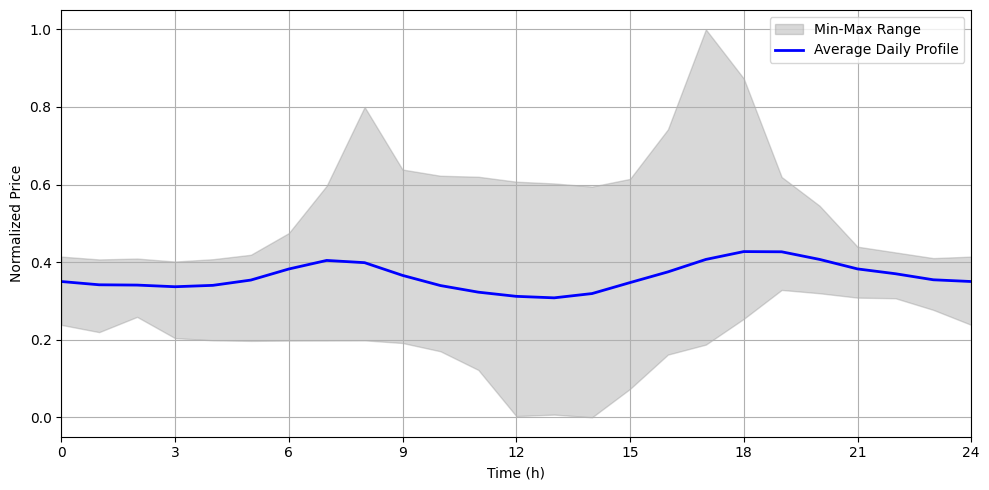


% ==============================
% BEGIN TIKZ FIGURE: fig04_price_data.ipynb
% ==============================


\begin{figure}[!t]
  \centering
  \begin{tikzpicture}
    \begin{axis}[
      width=0.45\textwidth,
      height=3.5cm,
      xlabel={Time (h)},
      ylabel={Normalized Price},
      xmin=0, xmax=24,
      xtick={0,3,...,24},
      grid=both,
      tick label style={font=\small},
      label style={font=\small},
      legend style={at={(0.5,1.01)}, 
      legend image post style={scale=1.0},
      anchor=south, legend columns=2, font=\small, draw=none}
    ]
    \addplot[name path=upper, draw=none, forget plot] table[x index=0,y index=1]{%
      0.0 0.41429592566118656
      1.0 0.4070050035739814
      2.0 0.40929235167977124
      3.0 0.4015725518227305
      4.0 0.4075768406004288
      5.0 0.4190135811293781
      6.0 0.47491065046461756
      7.0 0.5969978556111508
      8.0 0.7999999999999999
      9.0 0.6387419585418156
      10.0 0.6227305218012866
      11.0 0.6201

In [2]:
# Grouping by hour to get the mean, min, and max for each hour over all days
daily_profile = (
    df_resampled.groupby("hour")["price_normalized"]
    .agg(["mean", "min", "max"])
    .reset_index()
)

# Append the last point (24:00) to close the cycle, identical to hour 0
closing_point = daily_profile.iloc[0].copy()
closing_point["hour"] = 24
daily_profile = pd.concat(
    [daily_profile, closing_point.to_frame().T], ignore_index=True
)

# Plot
plt.figure(figsize=(10, 5))

# Shading: Min-Max Range
plt.fill_between(
    daily_profile["hour"],
    daily_profile["min"],
    daily_profile["max"],
    color="gray",
    alpha=0.3,
    label="Min-Max Range",
)

# Average Curve
plt.plot(
    daily_profile["hour"],
    daily_profile["mean"],
    color="blue",
    linewidth=2,
    label="Average Daily Profile",
)

# Axis Formatting
plt.xlabel("Time (h)")
plt.ylabel("Normalized Price")
plt.xticks(range(0, 25, 3))
plt.xlim(0, 24)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Grouping by hour
daily_profile = (
    df_resampled.groupby("hour")["price_normalized"]
    .agg(["mean", "min", "max"])
    .reset_index()
)
closing_point = daily_profile.iloc[0].copy()
closing_point["hour"] = 24
daily_profile = pd.concat(
    [daily_profile, closing_point.to_frame().T], ignore_index=True
)


# Prepare TikZ data
def format_coords(x, y):
    return "\n".join(f"      {xi:.1f} {yi}" for xi, yi in zip(x, y))


upper = format_coords(daily_profile["hour"], daily_profile["max"])
lower = format_coords(daily_profile["hour"], daily_profile["min"])
mean = format_coords(daily_profile["hour"], daily_profile["mean"])

# Generate TikZ code
tikz_code = f"""
\\begin{{figure}}[!t]
  \\centering
  \\begin{{tikzpicture}}
    \\begin{{axis}}[
      width=0.45\\textwidth,
      height=3.5cm,
      xlabel={{Time (h)}},
      ylabel={{Normalized Price}},
      xmin=0, xmax=24,
      xtick={{0,3,...,24}},
      grid=both,
      tick label style={{font=\\small}},
      label style={{font=\\small}},
      legend style={{at={{(0.5,1.01)}}, 
      legend image post style={{scale=1.0}},
      anchor=south, legend columns=2, font=\\small, draw=none}}
    ]
    \\addplot[name path=upper, draw=none, forget plot] table[x index=0,y index=1]{{%
{upper}
    }};
    \\addplot[name path=lower, draw=none, forget plot] table[x index=0,y index=1]{{%
{lower}
    }};
    \\addplot[gray, opacity=0.4] fill between[of=upper and lower];
    \\addlegendentry{{Min--Max Range}}
    \\addplot[blue, thick] table[x index=0,y index=1]{{%
{mean}
    }};
    \\addlegendentry{{Average Daily Profile}}
    \\end{{axis}}
  \\end{{tikzpicture}}
  \\caption{{Normalized daily electricity price profile based on EPEX Spot market prices for Austria (January–April 2025).}}
  \\label{{fig:daily_price_profile}}
\\end{{figure}}
"""
print("\n" + "% " + "=" * 30)
print("% BEGIN TIKZ FIGURE: fig04_price_data.ipynb")
print("% " + "=" * 30 + "\n")
print(tikz_code)
print("\n" + "% " + "=" * 30)
print("% END TIKZ FIGURE: fig04_price_data.ipynb")
print("% " + "=" * 30 + "\n")

In [3]:
print("Successfully generated LaTeX figure 04.")

Successfully generated LaTeX figure 04.
